In [1]:
# Import all the dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load the datasets into pandas dataframes
covid_df = pd.read_csv('../data/covidtesting.csv', engine='python')
vaccine_df = pd.read_csv('../data/vaccine_doses.csv', thousands=',', engine='python')
# Display what the raw data looks like
covid_df.head()

,Reported Date,Confirmed Negative,Presumptive Negative,Presumptive Positive,Confirmed Positive,Resolved,Deaths,Total Cases,Total patients approved for testing as of Reporting Date,Total tests completed in the last day,...,Number of patients in ICU on a ventilator due to COVID-19,Num. of patients in ICU on a ventilator testing positive,Num. of patients in ICU on a ventilator testing negative,Total Positive LTC Resident Cases,Total Positive LTC HCW Cases,Total LTC Resident Deaths,Total LTC HCW Deaths,Total_Lineage_B.1.1.7,Total_Lineage_B.1.351,Total_Lineage_P.1
0,2020-01-26,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-27,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-28,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-30,NaN,NaN,0.0,2.0,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-31,NaN,NaN,0.0,2.0,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Display what the raw data looks like
vaccine_df.head()

,report_date,previous_day_doses_administered,total_doses_administered,total_doses_in_fully_vaccinated_individuals,total_individuals_fully_vaccinated
0,2020-12-24,NaN,10756,NaN,NaN
1,2020-12-30,4595.0,18603,NaN,NaN
2,2020-12-31,5463.0,23502,NaN,NaN
3,2021-01-01,5415.0,28887,NaN,NaN
4,2021-01-02,4305.0,33191,NaN,NaN


In [4]:
# Rename the covid vaccines columns to match the formatting of other columns
# Also rename the 'report_date' column to be consistent with the other dataframe(s)
vaccine_df = vaccine_df.rename({'previous_day_doses_administered': 'Previous Day Doses Administered', 'report_date': 'Reported Date'}, axis='columns')

In [5]:
# Merge the datasets using 'report_date' as the unique identifier
merged_df = pd.merge(left=covid_df, right=vaccine_df, left_on='Reported Date', right_on='Reported Date')
# Remove the first two rows since we want to get rid of the 2020 rows
merged_df = merged_df.iloc[2:]
# Only select the columns we need/are interested in
merged_df = merged_df[['Reported Date', 'Deaths', 'Total Cases', 'Number of patients hospitalized with COVID-19', 'Previous Day Doses Administered']]
# Display the new merged dataframe
merged_df.head()

,Reported Date,Deaths,Total Cases,Number of patients hospitalized with COVID-19,Previous Day Doses Administered
2,2020-12-31,4530.0,182159.0,1235.0,5463.0
3,2021-01-01,4581.0,184635.0,1260.0,5415.0
4,2021-01-02,4625.0,187998.0,1003.0,4305.0
5,2021-01-03,4650.0,190962.0,998.0,4361.0
6,2021-01-04,4679.0,194232.0,1190.0,4808.0


In [6]:
# Shift Column 'Previous Day Doses Administered' up by one to make the data correspond to that same day
merged_df['Previous Day Doses Administered'] = merged_df['Previous Day Doses Administered'].shift(-1)

# Rename Column to reflect the above changes
merged_df = merged_df.rename({'Previous Day Doses Administered': 'Doses Administered'}, axis='columns')
merged_df.head()

,Reported Date,Deaths,Total Cases,Number of patients hospitalized with COVID-19,Doses Administered
2,2020-12-31,4530.0,182159.0,1235.0,5415.0
3,2021-01-01,4581.0,184635.0,1260.0,4305.0
4,2021-01-02,4625.0,187998.0,1003.0,4361.0
5,2021-01-03,4650.0,190962.0,998.0,4808.0
6,2021-01-04,4679.0,194232.0,1190.0,7607.0


In [7]:
# We need two more columns for New Deaths and New Cases since the data for that is currently a cumilitive total
new_cases = []
new_deaths = []

# Calculate daily change by getting the difference of one day from the previous day (for deaths and cases)
# Loop through all rows and do the above^
for i in range(2, len(merged_df.index)+2):
    if i < 98:
        new_cases.append(merged_df['Total Cases'][i+1] - merged_df['Total Cases'][i])
        new_deaths.append(merged_df['Deaths'][i+1] - merged_df['Deaths'][i])       

# Remove the first entry (December 31st, 2020) since it is used simply to get the values for January 1st, 2021
merged_df = merged_df.iloc[1:]

# Add the two new columns of data to the merged dataframe
merged_df['New Cases'] = new_cases
merged_df['New Deaths'] = new_deaths

#Remove the cumilitive total columns
merged_df = merged_df[['Reported Date', 'New Deaths', 'New Cases', 'Number of patients hospitalized with COVID-19', 'Doses Administered']]
merged_df.head()

,Reported Date,New Deaths,New Cases,Number of patients hospitalized with COVID-19,Doses Administered
3,2021-01-01,51.0,2476.0,1260.0,4305.0
4,2021-01-02,44.0,3363.0,1003.0,4361.0
5,2021-01-03,25.0,2964.0,998.0,4808.0
6,2021-01-04,29.0,3270.0,1190.0,7607.0
7,2021-01-05,51.0,3128.0,1347.0,10350.0


In [8]:
# Reset the index to start at 1
merged_df.index -= 2

# Remove the last row since there's no vaccination data for April 6th
merged_df = merged_df.iloc[:-1]
merged_df

,Reported Date,New Deaths,New Cases,Number of patients hospitalized with COVID-19,Doses Administered
1,2021-01-01,51.0,2476.0,1260.0,4305.0
2,2021-01-02,44.0,3363.0,1003.0,4361.0
3,2021-01-03,25.0,2964.0,998.0,4808.0
4,2021-01-04,29.0,3270.0,1190.0,7607.0
5,2021-01-05,51.0,3128.0,1347.0,10350.0
...,...,...,...,...,...
91,2021-04-01,23.0,2557.0,1116.0,88183.0
92,2021-04-02,23.0,3089.0,1162.0,59567.0
93,2021-04-03,16.0,3009.0,796.0,69125.0
94,2021-04-04,12.0,3041.0,811.0,52452.0


In [9]:
# Plot Variables against Time
x_dates = merged_df['Reported Date']
y = merged_df['New Cases']


In [27]:
id_var = merged_df.index
merged_df["Id"] = id_var
merged_df["Doses Administered"].corr(merged_df["New Deaths"])

-0.5214026798874095

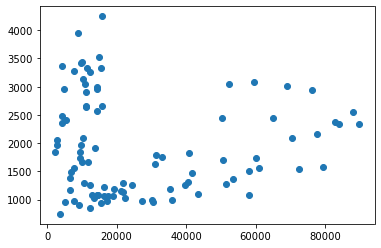

In [10]:
#create scatterplot
plt.scatter(x, y)

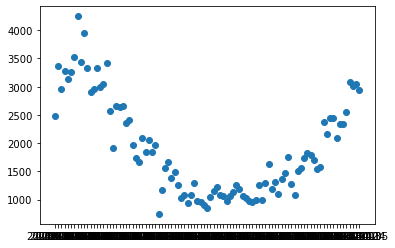

In [11]:
z = merged_df['Reported Date']
plt.scatter(z, y)

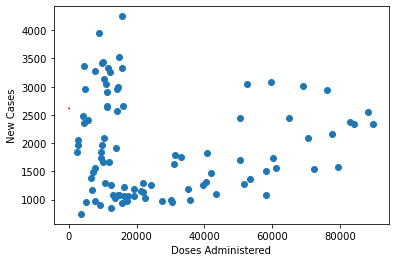

            3             2
-7.358e-12 x + 1.471e-06 x - 0.07424 x + 2616


In [12]:

#polynomial fit with degree = 2
model = np.poly1d(np.polyfit(x, y, 3))

#add fitted polynomial line to scatterplot
polyline = np.linspace(1, 100, 50)
plt.scatter(x, y)
plt.xlabel("Doses Administered")
plt.ylabel("New Cases")
plt.plot(polyline, model(polyline), "r")
plt.show()
print(model)

<AxesSubplot:xlabel='Reported Date', ylabel='New Deaths'>

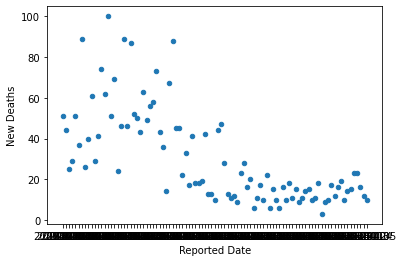

In [13]:
new_deaths_df = merged_df[['Reported Date', 'New Deaths']]

y = merged_df['New Cases']

new_deaths_df.plot.scatter(x='Reported Date', y='New Deaths')

<AxesSubplot:xlabel='Reported Date', ylabel='Number of patients hospitalized with COVID-19'>

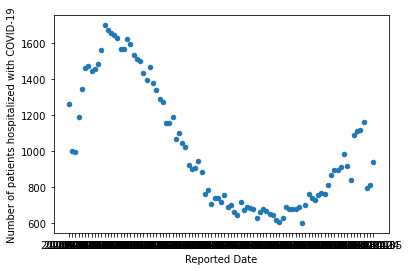

In [14]:
hospitalized_df = merged_df[['Reported Date', 'Number of patients hospitalized with COVID-19']]

y = merged_df['Number of patients hospitalized with COVID-19']

hospitalized_df.plot.scatter(x='Reported Date', y='Number of patients hospitalized with COVID-19')

<AxesSubplot:xlabel='Reported Date', ylabel='Doses Administered'>

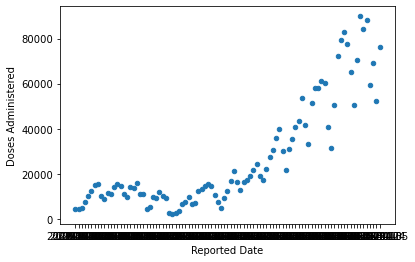

In [15]:
doses_df = merged_df[['Reported Date', 'Doses Administered']]

y = merged_df['Doses Administered']

doses_df.plot.scatter(x='Reported Date', y='Doses Administered')